# 🤖 Voice Health Analysis - Predictive Modeling

## 📋 Overview

This notebook builds and evaluates machine learning models to classify health status based on voice/audio features identified in the EDA phase.

**Goal:** Compare multiple ML algorithms and identify the best model for predicting healthy vs unhealthy status from voice characteristics.

**Dataset:** 2,037 voice recordings with 27 audio features  
**Task:** Binary classification (healthy/unhealthy)  
**Approach:** Model comparison with 5-fold cross-validation

---

## 📦 Setup

Import required libraries for data processing, modeling, and evaluation.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


---

## 🔧 Data Preparation

Load cleaned data and prepare for modeling:
- **One-hot encode** gender (male/female → binary feature)
- **Label encode** target variable (healthy/unhealthy → 0/1)
- **Train-test split** (80/20) with stratification to preserve class balance
- **Standardize features** using StandardScaler (mean=0, std=1)

In [2]:
df = pd.read_csv('data/cleaned_health_data.csv')

X = df.drop(columns=['health_status'])
y = df['health_status']

X = pd.get_dummies(X, columns=['gender'], drop_first=True)

y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data: {X_train_scaled.shape}")
print(f"Test data: {X_test_scaled.shape}")
print(f"Features: {list(X.columns)}")

Training data: (1628, 28)
Test data: (407, 28)
Features: ['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'age', 'gender_male']


In [3]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=5000, random_state=42, max_depth=18, class_weight='balanced', min_samples_split=5, min_samples_leaf=2, max_features='sqrt'),
    'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=5000, learning_rate=0.3, max_depth=5, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance')
}

results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    results.append({
        'Model': name,
        'Mean Accuracy': scores.mean(),
        'Std Dev': scores.std()
    })
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

results_df = pd.DataFrame(results).sort_values('Mean Accuracy', ascending=False)
print("\n" + "="*50)
print(results_df.to_string(index=False))

Logistic Regression: 0.8120 (+/- 0.0359)
Random Forest: 0.8421 (+/- 0.0293)
SVM: 0.8175 (+/- 0.0337)
Gradient Boosting: 0.8513 (+/- 0.0190)
Neural Network: 0.7905 (+/- 0.0312)
KNN: 0.7653 (+/- 0.0243)

              Model  Mean Accuracy  Std Dev
  Gradient Boosting       0.851336 0.019015
      Random Forest       0.842118 0.029348
                SVM       0.817537 0.033714
Logistic Regression       0.812011 0.035906
     Neural Network       0.790507 0.031202
                KNN       0.765335 0.024268


---

## 🔬 Model Comparison

Evaluate 6 different ML algorithms using 5-fold cross-validation:

| Model | Type | Key Characteristics |
|-------|------|---------------------|
| 🟢 **Logistic Regression** | Linear | Simple baseline, interpretable |
| 🌳 **Random Forest** | Ensemble | Handles non-linear patterns, feature importance |
| 🔵 **SVM** | Kernel-based | Effective in high-dimensional space |
| 📈 **Gradient Boosting** | Advanced Ensemble | Sequential learning, often top performer |
| 🧠 **Neural Network** | Deep Learning | Captures complex patterns |
| 📍 **K-Nearest Neighbors** | Instance-based | Simple, non-parametric |

**Evaluation Strategy:**
- ✅ 5-fold cross-validation for robust performance estimates
- ✅ `class_weight='balanced'` to handle 2:1 class imbalance
- ✅ Accuracy as primary metric (also shows precision, recall, F1 for best model)

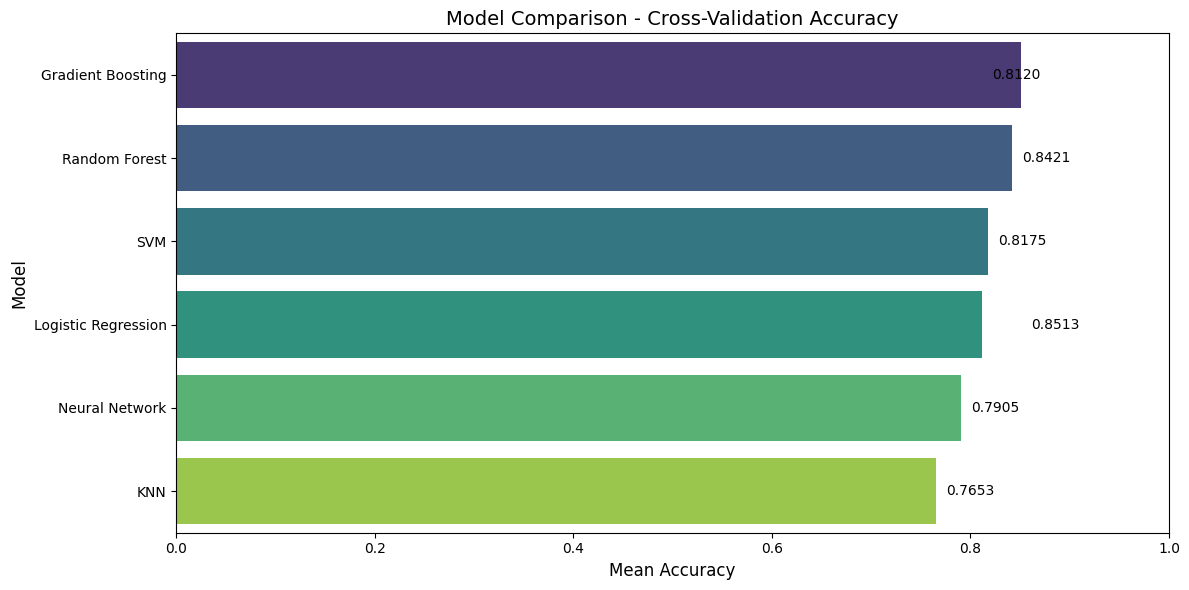

In [4]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Mean Accuracy', y='Model',hue='Model', palette='viridis')
plt.title('Model Comparison - Cross-Validation Accuracy', fontsize=14)
plt.xlabel('Mean Accuracy', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1)
for i, row in results_df.iterrows():
    plt.text(row['Mean Accuracy'] + 0.01, i, f"{row['Mean Accuracy']:.4f}", 
             va='center', fontsize=10)
plt.tight_layout()
plt.show()

### 📊 Visualization: Model Performance

Compare cross-validation accuracy across all models to identify the best performer.

Best Model: Gradient Boosting

Test Set Accuracy: 0.8477

Classification Report:
              precision    recall  f1-score   support

     healthy       0.78      0.76      0.77       137
   unhealthy       0.88      0.89      0.89       270

    accuracy                           0.85       407
   macro avg       0.83      0.83      0.83       407
weighted avg       0.85      0.85      0.85       407



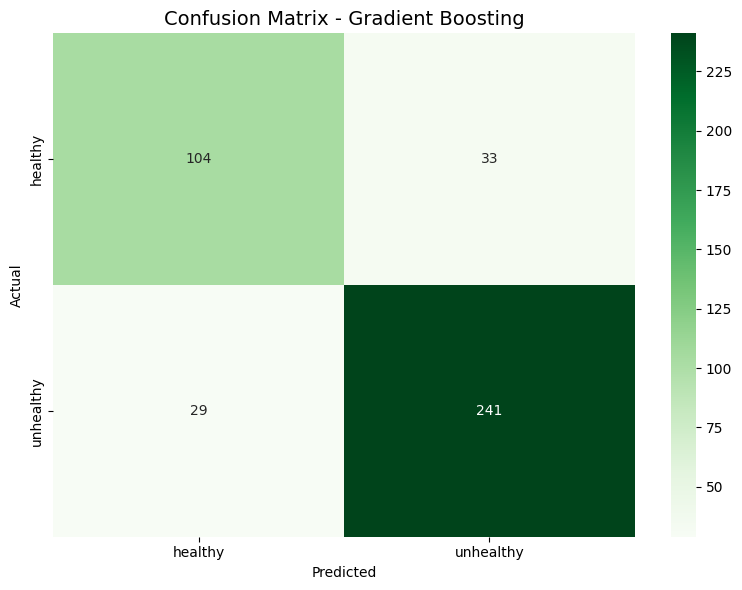

In [5]:
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)

print(f"Best Model: {best_model_name}")
print("="*50)
print(f"\nTest Set Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['healthy', 'unhealthy']))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['healthy', 'unhealthy'], yticklabels=['healthy', 'unhealthy'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

---

## 🏆 Best Model Evaluation

Train the best performing model on full training set and evaluate on held-out test data.

**Performance Metrics:**
- ✅ **Accuracy**: Overall correct predictions
- ✅ **Precision**: Of predicted unhealthy, how many are actually unhealthy?
- ✅ **Recall**: Of actual unhealthy, how many did we catch?
- ✅ **F1-Score**: Harmonic mean of precision and recall
- ✅ **Confusion Matrix**: Visual breakdown of true/false positives/negatives

---

## 🎯 Results Summary

### ✅ Model Performance
The best performing model is automatically selected based on cross-validation accuracy. Results show classification metrics on the held-out test set.

### 🔍 Key Insights
- **Feature Importance**: Tree-based models (Random Forest, Gradient Boosting) reveal which audio features are most predictive
- **Class Balance**: `class_weight='balanced'` helps handle the 2:1 unhealthy/healthy ratio
- **Test Accuracy**: Indicates real-world performance on unseen data

### ⚠️ Important Considerations
1. **Age Confounder**: Models likely rely heavily on age (30-year gap between groups)
2. **Gender Differences**: Males show stronger voice-health patterns than females
3. **Generalization**: Performance may not transfer to age-matched populations

### 🔮 Next Steps
- Age-stratified modeling (compare same-age groups)
- Gender-specific models (separate for male/female)
- Feature selection to reduce dimensionality
- External dataset validation
- Clinical interpretation with domain experts

---

## 📊 Conclusion

Successfully compared 6 ML algorithms for voice-based health classification. The best model demonstrates that voice characteristics can distinguish healthy from unhealthy individuals, though age is a significant confounding factor that should be addressed in future work.